# Capital Asset Price Model (CAPM) to Model Cryptocurrency 

In [1]:
# Import modules
import pandas as pd
import numpy as np
import yfinance as yf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.iolib.summary2 import summary_col
import statsmodels.stats.diagnostic as dx
%matplotlib inline

# *Part 1 - Gathering Data*

## Download Cryptocurrency Historical Data
I selected several of the highest market cap cryptocurrencies

In [2]:
# Select 4 crypto-currencies
cryptocurrencies = ["BTC-USD", "ETH-USD", "USDT-USD", "XRP-USD"]

# Download 
yft = yf.Ticker

hist = []

for symbol in tqdm(cryptocurrencies):
    ticker_i = yft(symbol)
    
    try:
        if ticker_i.history is not None:
            hist_data = pd.DataFrame(ticker_i.history(period = "max"))
            hist_data.index = pd.to_datetime(hist_data.index)
            df_new = pd.DataFrame()
            df_new[str(ticker_i.ticker)] = hist_data["Close"]
            hist.append(df_new)
            
    except IndexError:
        pass

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.54s/it]


In [3]:
crypto = pd.concat(hist, axis = 1)
crypto.rename(columns = {'BTC-USD': 'BTC', 'ETH-USD': 'ETH', "USDT-USD": "USDT", "XRP-USD": "XRP"}, inplace = True)

# Cutting off excess dataframe 
crypto = crypto[crypto["ETH"].notna()]
crypto

,BTC,ETH,USDT,XRP
Date,,,,
2017-11-09,7143.580078,320.884003,1.008180,0.217488
2017-11-10,6618.140137,299.252991,1.006010,0.206483
2017-11-11,6357.600098,314.681000,1.008990,0.210430
2017-11-12,5950.069824,307.907990,1.012470,0.197339
2017-11-13,6559.490234,316.716003,1.009350,0.203442
...,...,...,...,...
2022-10-19,19139.535156,1285.744263,1.000060,0.451227
2022-10-20,19053.740234,1283.200928,0.999994,0.448084
2022-10-21,19172.468750,1299.946411,1.000123,0.461098


In [4]:
log_crypto = crypto.pct_change().apply(lambda x: np.log(x+1)*100)
log_crypto

,BTC,ETH,USDT,XRP
Date,,,,
2017-11-09,NaN,NaN,NaN,NaN
2017-11-10,-7.639968,-6.979036,-0.215468,-5.192559
2017-11-11,-4.016342,5.027009,0.295781,1.893492
2017-11-12,-6.624801,-2.175842,0.344302,-6.422998
2017-11-13,9.750994,2.820448,-0.308639,3.045793
...,...,...,...,...
2022-10-19,-1.013062,-1.903057,-0.004601,-3.216575
2022-10-20,-0.449268,-0.198006,-0.006598,-0.698985
2022-10-21,0.621191,1.296536,0.012904,2.862986


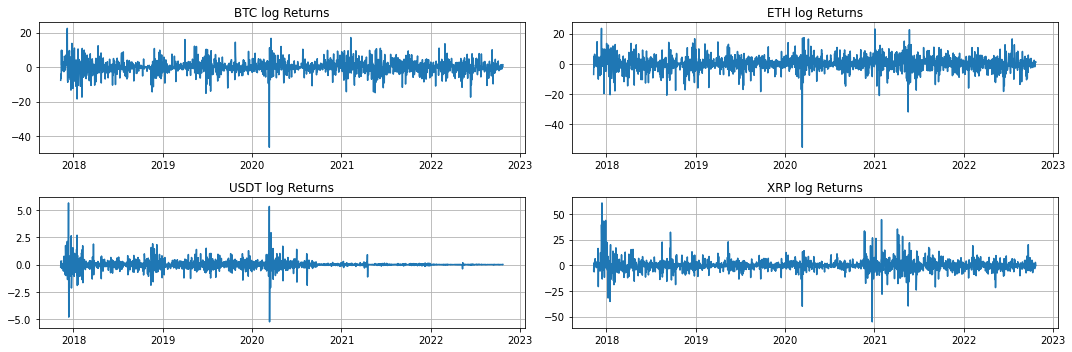

In [5]:
plt.figure(figsize = (15,5))
for i, col in enumerate(log_crypto):
    plt.subplot(2, 2, i+1)
    plt.title(f"{col} log Returns")
    plt.plot(log_crypto[col])
    plt.grid()
    plt.tight_layout()

## Download S&P500 Historical Data (growth rate)

In [6]:
# Read in s&p500 data 
sp = pd.read_csv(r"C:\Users\Csome\Downloads\SP500.csv")

# Fixing date format and adding non-trading days 
sp["DATE"] = pd.to_datetime(sp["DATE"], format="%Y-%m")
sp = sp.set_index("DATE")
start_date = sp.index.min()
end_date = sp.index.max()
dates = pd.date_range(start_date, end_date, freq="D")
dates.name = "Date"
sp = sp.reindex(dates)
sp.head()

,SP500
Date,
2017-11-09,2584.62
2017-11-10,2582.3
2017-11-11,NaN
2017-11-12,NaN
2017-11-13,2584.84


In [7]:
# FRED uses "." to fill for NaN values...
# S&P500 does not trade on weekdays, while crypto does
# Looping through all values to catch all invalid points, interpolating (back forth averaging)
sp_500 = []
for i, value in enumerate(sp["SP500"]):
    if len(str(value))<2:
        sp_500.append(None)
    else:
        sp_500.append(value)
        
sp["SP500"] = sp_500
sp = sp.astype(float)

sp.interpolate(inplace = True)

sp.head()

,SP500
Date,
2017-11-09,2584.620000
2017-11-10,2582.300000
2017-11-11,2583.146667
2017-11-12,2583.993333
2017-11-13,2584.840000


In [8]:
growth_rate = sp.pct_change().apply(lambda x: np.log(x+1)*100)
growth_rate.head()

,SP500
Date,
2017-11-09,NaN
2017-11-10,-0.089802
2017-11-11,0.032782
2017-11-12,0.032771
2017-11-13,0.032760


Text(0.5, 1.0, 'S&P500 Log Returns')

<Figure size 1080x576 with 0 Axes>

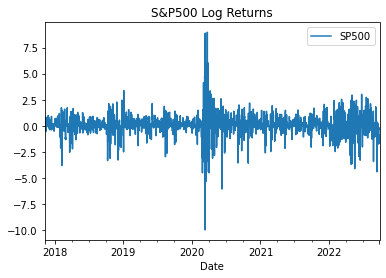

In [9]:
plt.figure(figsize = (15,8))
growth_rate.plot()
plt.title("S&P500 Log Returns")

## Download Historical (Effective) Federal Funds Rate (risk-free rate)

In [10]:
# Reading in eFFR Data from FRED
rf = pd.read_csv(r"C:\Users\Csome\Downloads\FEDFUNDS.csv")

# Setting date time index to be accepted by pandas 
rf["DATE"] = pd.to_datetime(rf["DATE"], format = "%Y-%m")
rf = rf.set_index("DATE")
rf.head()

,FEDFUNDS
DATE,
2017-11-01,1.16
2017-12-01,1.30
2018-01-01,1.41
2018-02-01,1.42
2018-03-01,1.51


In [11]:
# Upsampling data- monthly to daily, for analysis
start_date = rf.index.min() + pd.DateOffset(day=9)
end_date = rf.index.max() + pd.DateOffset(day=31)

dates = pd.date_range(start_date, end_date, freq="D")
dates.name = "Date"
rf = rf.reindex(dates, method="ffill")
rf.head()

,FEDFUNDS
Date,
2017-11-09,1.16
2017-11-10,1.16
2017-11-11,1.16
2017-11-12,1.16
2017-11-13,1.16


<AxesSubplot:xlabel='Date'>

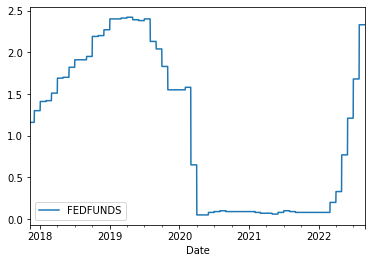

In [12]:
rf.plot()

## Combine Gathered Historical Data

In [13]:
# Combine the 3 Datasets 
capm_data = pd.concat([log_crypto, growth_rate, rf], axis = 1)

print(log_crypto.shape, growth_rate.shape, rf.shape)

(1810, 4) (1784, 1) (1757, 1)


In [14]:
capm_data = capm_data[capm_data["FEDFUNDS"].notna() & capm_data["SP500"].notna()]

for col in capm_data:
    if col != "FEDFUNDS":
        capm_data[col] = capm_data[col] - capm_data["FEDFUNDS"]
    
capm_data

,BTC,ETH,USDT,XRP,SP500,FEDFUNDS
Date,,,,,,
2017-11-10,-8.799968,-8.139036,-1.375468,-6.352559,-1.249802,1.16
2017-11-11,-5.176342,3.867009,-0.864219,0.733492,-1.127218,1.16
2017-11-12,-7.784801,-3.335842,-0.815698,-7.582998,-1.127229,1.16
2017-11-13,8.590994,1.660448,-1.468639,1.885793,-1.127240,1.16
2017-11-14,-0.004119,5.234813,-1.409974,1.929283,-1.391229,1.16
...,...,...,...,...,...,...
2022-08-27,-3.413245,-3.422832,-2.332408,-3.227415,-2.552461,2.33
2022-08-28,-4.472993,-6.495479,-2.329094,-6.051943,-2.552957,2.33
2022-08-29,1.083499,5.885545,-2.329607,0.928667,-2.553455,2.33


In [15]:
capm_data.describe()

,BTC,ETH,USDT,XRP,SP500,FEDFUNDS
count,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000
mean,-1.018838,-0.987784,-1.078071,-1.054233,-1.053383,1.077608
std,4.222052,5.320803,1.039924,6.548065,1.386954,0.931571
min,-47.123018,-55.723174,-6.119841,-55.140256,-10.644485,0.050000
25%,-2.944280,-3.559202,-1.959201,-3.650313,-1.992630,0.090000
50%,-1.021185,-1.060938,-1.155976,-1.225936,-1.145423,1.300000
75%,1.053336,1.814396,-0.097775,1.215681,-0.050421,1.910000
max,21.211895,22.979523,4.689340,59.388530,8.318316,2.420000


# *Part 2 - CAPM Modelling*

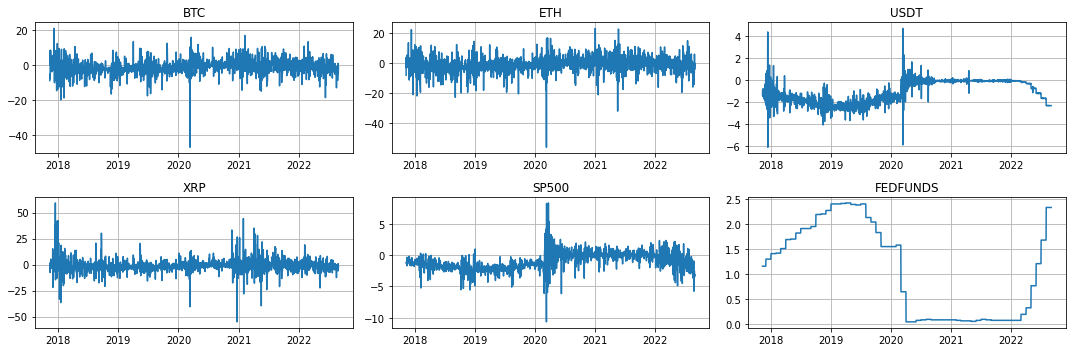

In [16]:
plt.figure(figsize = (15,5))
for i, col in enumerate(capm_data):
    plt.subplot(2, 3, i+1)
    plt.title(col)
    plt.plot(capm_data[col])
    plt.grid()
    plt.tight_layout()

In [17]:
capm_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1756 entries, 2017-11-10 to 2022-08-31
Freq: D
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BTC       1756 non-null   float64
 1   ETH       1756 non-null   float64
 2   USDT      1756 non-null   float64
 3   XRP       1756 non-null   float64
 4   SP500     1756 non-null   float64
 5   FEDFUNDS  1756 non-null   float64
dtypes: float64(6)
memory usage: 96.0 KB


### CAPM Model 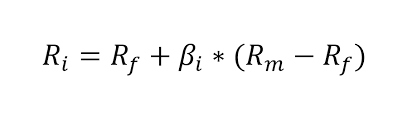

#### Beta 
- The market has a Beta = 1 
- Crypto with a Beta > 1 are more volatile, while those < 1 are less.
- A positive Beta suggests the crypto moves with the market, negative moves against

#### Alpha 
- Alpha is excess returns (over market)

In [18]:
capm_data.head()

,BTC,ETH,USDT,XRP,SP500,FEDFUNDS
Date,,,,,,
2017-11-10,-8.799968,-8.139036,-1.375468,-6.352559,-1.249802,1.16
2017-11-11,-5.176342,3.867009,-0.864219,0.733492,-1.127218,1.16
2017-11-12,-7.784801,-3.335842,-0.815698,-7.582998,-1.127229,1.16
2017-11-13,8.590994,1.660448,-1.468639,1.885793,-1.127240,1.16
2017-11-14,-0.004119,5.234813,-1.409974,1.929283,-1.391229,1.16


### Helper Functions

In [19]:
def OLS_estimation(crypto, 
                   se_type, 
                   rs = 101, 
                   split = False, 
                   const = True):
    """
    Estimating Linear Regression (OLS)
    
    se_type: str, standard error type ("r" or "n")
    rs: int, random_seed for shuffling samples (n = 200)
    split: boolean, sample splitting (True, False)
    const: boolean, y-intercept (True, False)
    """
    if split is False:
        # Setting outcome and regressors
        y = capm_data[crypto]
        x = capm_data["SP500"]
    else:
        shuffled = capm_data.sample(frac = 1, random_state = rs)
        y = shuffled.head(200)[crypto]
        x = shuffled.head(200)["SP500"]
    
    if const is True:
        # Add constant as Beta_1 then fit 
        x1 = sm.add_constant(x)
        model = sm.OLS(y, x1)
    else:
        # Fit OLS model
        model = sm.OLS(y, x)
    
    if se_type == "n":   
        results = model.fit()
        residuals[crypto] = results.resid
        fitted[crypto] = results.fittedvalues
        if const is True: 
            alpha[crypto], beta[crypto] = results.params
            se[crypto] = results.bse[1]
    
    if se_type == "r":
        results = model.fit(cov_type='HAC', cov_kwds={'maxlags':12,'use_correction':True})
        residuals_r[crypto] = results.resid
        fitted_r[crypto] = results.fittedvalues
        if const is True:
            alpha_r[crypto], beta_r[crypto] = results.params
            se_r[crypto] = results.bse[1]
    
    return results

In [20]:
def plot_residuals(results, crypto):
    """
    Plot residuals from OLS regression
    """
    # Calculating residuals 
    residuals[crypto] = results.resid
    fitted[crypto] = results.fittedvalues
    
    # Plotting residuals
    fig, ax = plt.subplots(figsize = (10, 5))
    fig = plt.scatter(results.fittedvalues, results.resid, alpha = 0.5)
    #ax = sns.jointplot(x = results.fittedvalues, y = results.resid, kind='hex', height = 8)
    plt.title(f"{crypto} Actual vs. Predicted")
    plt.xlabel(f"{crypto} Fitted Values/Estimates")
    plt.ylabel("Residuals")
    
    # Line of best fit
    coeff, ssr, _, _, _ = np.polyfit(results.fittedvalues, residuals[crypto], 1, full = True)
    plt.plot(capm_data['SP500'], coeff[0] * capm_data['SP500'] + coeff[1], "-", color = 'r')
    
    return fig

### Statistical Test Functions 

In [21]:
def bg(results, crypto, se_type):
    """
    Breusch-Godfrey test to test for autocorrelation among the residuals at order p
    """
    # Breusch Godfrey Test
    keys = ['Breusch Godfrey Lagrange Multiplier Statistic', 'BG p-value', 'BG f-value', 'BG f p-value']
    # Parameters: 
    #1. Estimation results for which the residuals are tested for serial correlation
    #2. Number of lags to include in the auxiliary regression. (nlags is highest lag)
    breusch_godfrey_test = list(sms.acorr_breusch_godfrey(results, nlags =12))
    b_g = dict(zip(keys, breusch_godfrey_test))
    
    if se_type == "n":
        bg_test[crypto] = b_g
    if se_type == "r":
        bg_test_r[crypto] = b_g
    
    return 

In [22]:
def gq(results, crypto, se_type): 
    """
    Goldfeld-Quandt Test to test whether variance is the same in 2 subsamples 
    Indictation for the presence of Heteroscedasticity
    """
    # Goldfeld-Quandt Test for residual variance 
    keys = ['GQ F-statistic', 'GQ p-value']
    # 0<split<1 then split is interpreted as fraction of the observations in the first sample
    goldfeldquandt_test = list(sms.het_goldfeldquandt(results.resid, results.model.exog,split=0.5))
    g_q = dict(zip(keys, goldfeldquandt_test))
    
    if se_type == "n":
        gq_test[crypto] = g_q
    if se_type == "r":
        gq_test_r[crypto] = g_q
    
    return 

In [23]:
def bp(results, crypto, se_type):
    """
    Perform bp testing if residuals are heteroskedastic
    """
    # Breush-Pagan Test for Heteroskedasticity 
    keys = ['Breush-Pagan Lagrange Multiplier Statistic', 'BP p-value', 'BP f-value', 'BP f p-value']
    breushpagan_test = list(sms.het_breuschpagan(results.resid, results.model.exog))
    b_p = dict(zip(keys, breushpagan_test))
    
    if se_type == "n":
        bp_test[crypto] = b_p
    if se_type == "r":
        bp_test_r[crypto] = b_p
    
    return 

In [24]:
def white(results, crypto, se_type):
    """
    Perform white testing if residuals are heteroskedastic
    """
    # Whites test for Heteroskedasticity 
    keys = ['White Lagrange Multiplier Statistic', 'White p-value','White f-statistic', 'White f p-value']
    white_t = list(sms.het_white(results.resid, results.model.exog))
    w = dict(zip(keys, white_t))
    
    if se_type == "n":
        white_test[crypto] = w
    if se_type == "r":
        white_test_r[crypto] = w
        
    return 

In [25]:
def dw_test(results, crypto, se_type):
    """
    Performs Durbin Watson test for serial correlation 
    """
    durbin_watson_test = sms.durbin_watson(results.resid)
    
    if se_type == "n":
        dw[crypto] = durbin_watson_test
    if se_type == "r":
        dw_r[crypto] = durbin_watson_test
        
    return 

In [26]:
def jb_test(results, crypto, se_type):
    """
    Performs Jarque-Bera Test for normality
    """
    keys = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skewness', 'Kurtosis']
    jarquebera_test = list(sms.jarque_bera(results.resid))
    jb_ = dict(zip(keys, jarquebera_test))
    
    if se_type == "n":
        jb[crypto] = jb_
    if se_type == "r":
        jb_r[crypto] = jb_
        
    return 

In [27]:
def main(crypto, 
         se_type = "n", 
         rs = 101, 
         split = False, 
         const = True):
    """
    OLS estimation for either normal or robust standard errors
    
    se_type: str, standard error type ("r" or "n")
    rs: int, random_seed for shuffling samples noted to ensure reproducibility (n = 200)
    split: boolean, sample splitting (True, False)
    const: boolean, y-intercept (True, False)
    """
    # 1. Getting OLS results
    results = OLS_estimation(crypto, se_type, rs, split, const)
    
    # 2. Performing Statistical tests for OLS assumptions (saving in dictionary of dictionary for comparison)
    if const is True:
        white(results, crypto, se_type)
        bp(results, crypto, se_type)
        
    gq(results, crypto, se_type)
    bg(results, crypto, se_type)
    dw_test(results, crypto, se_type)
    jb_test(results, crypto, se_type)
    
    # Print OLS
    if se_type == "n" and const is True and split is False:
        # 3. Plotting Residuals 
        fig = plot_residuals(results, crypto)
        print(f"====================================={crypto}======================================\n{results.summary()}\n")
        
    return results

In [28]:
# Defining dictionaries for closer inspection and use in CAPM Model
residuals = {}
results = {}
fitted = {}
se = {}
beta = {}
gq_test = {}
white_test = {}
bp_test = {}
bg_test = {}
dw = {}
alpha = {}
jb = {}

# Robust dictionaries 
residuals_r = {}
results_r = {}
fitted_r = {}
jb_r = {}
se_r = {}
beta_r = {}
gq_test_r = {}
white_test_r = {}
dw_r = {}
bp_test_r = {}
bg_test_r = {}
alpha_r = {}

### BTC 

=====================================BTC======================================
                            OLS Regression Results                            
Dep. Variable:                    BTC   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     229.0
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           1.03e-48
Time:                        21:55:00   Log-Likelihood:                -4912.6
No. Observations:                1756   AIC:                             9829.
Df Residuals:                    1754   BIC:                             9840.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

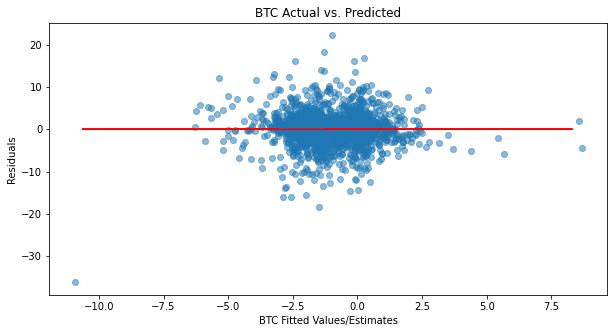

In [29]:
results["BTC"] = main("BTC")
results["BTC"]

### ETH

=====================================ETH======================================
                            OLS Regression Results                            
Dep. Variable:                    ETH   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     217.8
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           1.49e-46
Time:                        21:55:00   Log-Likelihood:                -5323.8
No. Observations:                1756   AIC:                         1.065e+04
Df Residuals:                    1754   BIC:                         1.066e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

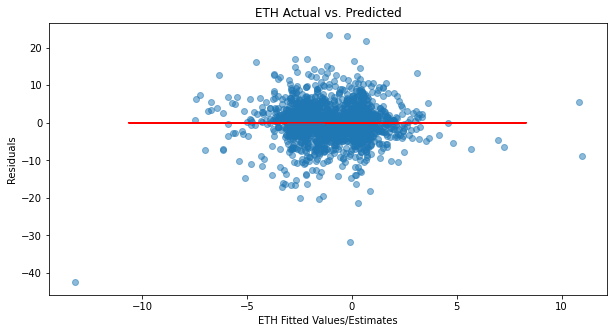

In [30]:
results["ETH"] = main("ETH")
results["ETH"]

### USD-T

=====================================USDT======================================
                            OLS Regression Results                            
Dep. Variable:                   USDT   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     856.8
Date:                Sun, 23 Oct 2022   Prob (F-statistic):          1.04e-153
Time:                        21:55:00   Log-Likelihood:                -2210.7
No. Observations:                1756   AIC:                             4425.
Df Residuals:                    1754   BIC:                             4436.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

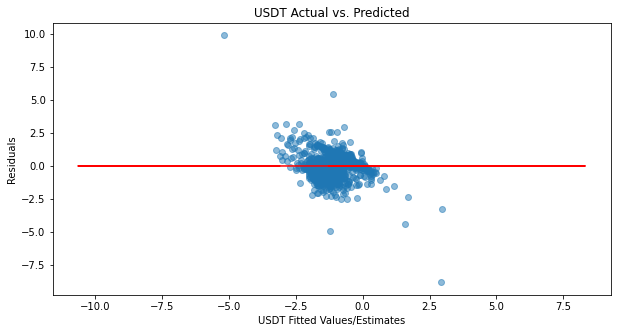

In [31]:
results["USDT"] = main("USDT")
results["USDT"]

### XRP

=====================================XRP======================================
                            OLS Regression Results                            
Dep. Variable:                    XRP   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     110.6
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           4.01e-25
Time:                        21:55:00   Log-Likelihood:                -5737.3
No. Observations:                1756   AIC:                         1.148e+04
Df Residuals:                    1754   BIC:                         1.149e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

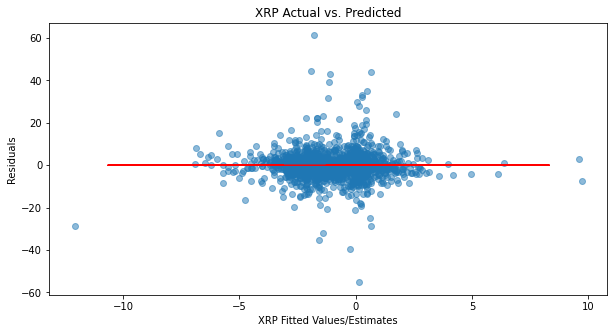

In [32]:
results["XRP"] = main("XRP")
results["XRP"]

In [33]:
for i in results:
    print(f"====================================={i}======================================\n{results[i].summary()}\n")

=====================================BTC======================================
                            OLS Regression Results                            
Dep. Variable:                    BTC   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     229.0
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           1.03e-48
Time:                        21:55:01   Log-Likelihood:                -4912.6
No. Observations:                1756   AIC:                             9829.
Df Residuals:                    1754   BIC:                             9840.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [34]:
headers = ["BTC", "ETH", "USDT", "XRP"]
    
results_list = [results["BTC"],
                results["ETH"],
                results["USDT"],
                results["XRP"]]

result_table = summary_col(results_list,
                           float_format = "%0.3f",
                           stars = True, 
                           model_names = headers)

In [35]:
result_table

,BTC,ETH,USDT,XRP
const,0.071,0.355**,-0.626***,0.157
,(0.119),(0.150),(0.026),(0.190)
SP500,1.034***,1.275***,0.430***,1.150***
,(0.068),(0.086),(0.015),(0.109)
R-squared,0.115,0.110,0.328,0.059
R-squared Adj.,0.115,0.110,0.328,0.059


In [36]:
beta_df = pd.DataFrame(beta, index = ["Estimated Beta"]).T
beta_df.round(2)

,Estimated Beta
BTC,1.03
ETH,1.28
USDT,0.43
XRP,1.15


### Residual Testing 

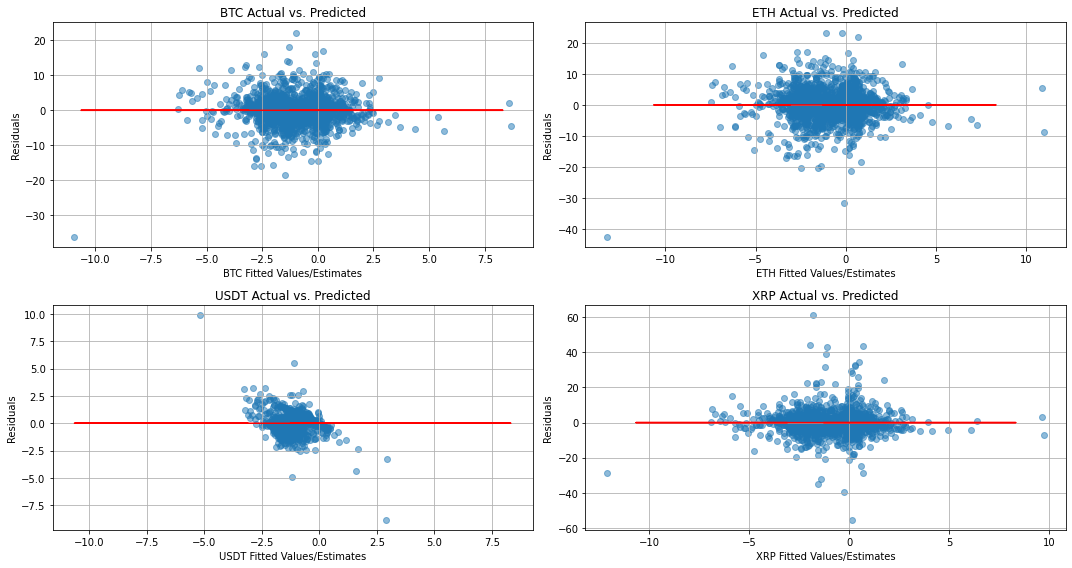

In [37]:
fig, ax = plt.subplots(figsize = (15, 8))
for i, crypto in enumerate(residuals):
    plt.subplot(2, 2, i+1)
    # Plotting residuals
    plt.scatter(fitted[crypto], residuals[crypto], alpha = 0.5)
    #sns.jointplot(x = fitted[crypto], y = residuals[crypto], kind='hex', height = 8)
    plt.title(f"{crypto} Actual vs. Predicted")
    plt.xlabel(f"{crypto} Fitted Values/Estimates")
    plt.ylabel("Residuals")
    # Line of best fit
    coeff, ssr, _, _, _ = np.polyfit(fitted[crypto], residuals[crypto], 1, full = True)
    plt.plot(capm_data['SP500'], coeff[0] * capm_data['SP500'] + coeff[1], "-", color = 'r')
    plt.grid()
    plt.tight_layout()

## C. Statistical Tests (for OLS Assumptions)

In [38]:
jb_test_df = round(pd.DataFrame(jb),3)
jb_test_df

,BTC,ETH,USDT,XRP
Jarque-Bera,3082.940,2299.287,24548.257,21206.258
Chi^2 two-tail prob.,0.000,0.000,0.000,0.000
Skewness,-0.357,-0.527,0.248,0.954
Kurtosis,9.452,8.506,21.310,19.917


In [39]:
gq_test = pd.DataFrame(gq_test)
gq_test

,BTC,ETH,USDT,XRP
GQ F-statistic,0.628241,0.794852,0.415775,0.979665
GQ p-value,1.000000,0.999654,1.000000,0.619413


In [40]:
white_test = pd.DataFrame(white_test)
white_test

,BTC,ETH,USDT,XRP
White Lagrange Multiplier Statistic,2.154564e+02,1.948945e+02,7.844842e+02,1.782543
White p-value,1.637671e-47,4.777390e-43,4.481382e-171,0.410134
White f-statistic,1.225850e+02,1.094257e+02,7.077605e+02,0.890653
White f p-value,1.480844e-50,1.650551e-45,4.721279e-226,0.410573


In [41]:
bp_test = pd.DataFrame(bp_test)
bp_test

,BTC,ETH,USDT,XRP
Breush-Pagan Lagrange Multiplier Statistic,3.464931e+01,3.014490e+01,6.618023,0.465865
BP p-value,3.947784e-09,4.009395e-08,0.010095,0.494895
BP f-value,3.530651e+01,3.063650e+01,6.635494,0.465458
BP f p-value,3.389912e-09,3.582288e-08,0.010078,0.495174


In [42]:
round(bp_test,2)

,BTC,ETH,USDT,XRP
Breush-Pagan Lagrange Multiplier Statistic,34.65,30.14,6.62,0.47
BP p-value,0.00,0.00,0.01,0.49
BP f-value,35.31,30.64,6.64,0.47
BP f p-value,0.00,0.00,0.01,0.50


In [43]:
bg_test = pd.DataFrame(bg_test)
bg_test

,BTC,ETH,USDT,XRP
Breusch Godfrey Lagrange Multiplier Statistic,22.016025,22.984104,1.109344e+03,20.841847
BG p-value,0.037341,0.027861,5.674798e-230,0.052745
BG f-value,1.843150,1.925271,2.474286e+02,1.743669
BG f p-value,0.037057,0.027581,0.000000e+00,0.052484


In [44]:
dw

{'BTC': 2.0428338663868053,
 'ETH': 2.0835703095719027,
 'USDT': 1.5589287384823451,
 'XRP': 1.9835365018685338}

In [45]:
diagnostic_tests = round(pd.concat([gq_test, white_test, bp_test, bg_test]), 3)
diagnostic_tests

,BTC,ETH,USDT,XRP
GQ F-statistic,0.628,0.795,0.416,0.980
GQ p-value,1.000,1.000,1.000,0.619
White Lagrange Multiplier Statistic,215.456,194.895,784.484,1.783
White p-value,0.000,0.000,0.000,0.410
White f-statistic,122.585,109.426,707.760,0.891
White f p-value,0.000,0.000,0.000,0.411
Breush-Pagan Lagrange Multiplier Statistic,34.649,30.145,6.618,0.466
BP p-value,0.000,0.000,0.010,0.495
BP f-value,35.307,30.637,6.635,0.465
BP f p-value,0.000,0.000,0.010,0.495


c:\users\csome\python\pythonproject\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\csome\python\pythonproject\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\csome\python\pythonproject\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

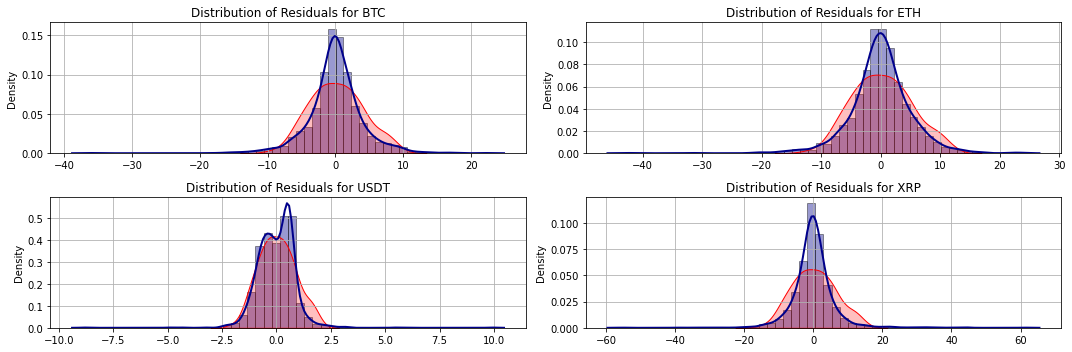

In [46]:
plt.figure(figsize = (15,5))
for i, crypto in enumerate(residuals):
    plt.subplot(2, 2, i+1)
    plt.title(f"Distribution of Residuals for {crypto}")
    sns.distplot(residuals[crypto], hist=True, kde=True, color='darkblue',hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2})
    np.random.seed(0)
    # Random variable with normal distribution
    normal_sample = np.random.normal(np.mean(residuals[crypto]),np.std(residuals[crypto]), 249)
    # Applying the Gaussian kernel density estimate to get the density curve
    sns.kdeplot(normal_sample, color = 'red', shade=True) 
    
    plt.grid()
    plt.tight_layout()

## D. OLS Re-Calculated with Robust Standard Errors 

### Robust-BTC

In [47]:
def tabulate(results, 
             results_r, 
             n, 
             s1 = None, 
             s1_r = None, 
             s2 = None, 
             s2_r = None, 
             no_con = None,
             no_con_r = None):
    """
    Turning OLS to table for comparison of models with changing parameters
    """
    headers = ["non_robust_OLS", "robust_OLS", 
               "sample_1", "rob_sample_1", 
               "sample_2", "rob_sample_2",
               "no_constant", "rob_no_con"]
    
    results_list = [results, 
                    results_r,
                    s1, s1_r,
                    s2, s2_r,
                    no_con, no_con_r]
    
    result_table = summary_col(results_list[:n+1],
                               float_format = "%0.3f",
                               stars = True, 
                               model_names = headers[:n+1])
    
    return result_table

In [48]:
results_r["BTC"] = main("BTC", "r")
tabulate(results["BTC"], results_r["BTC"], 1)

,non_robust_OLS,robust_OLS
const,0.071,0.071
,(0.119),(0.133)
SP500,1.034***,1.034***
,(0.068),(0.111)
R-squared,0.115,0.115
R-squared Adj.,0.115,0.115


### Robust-ETH

In [49]:
results_r["ETH"] = main("ETH", "r")
tabulate(results["ETH"], results_r["ETH"], 1)

,non_robust_OLS,robust_OLS
const,0.355**,0.355**
,(0.150),(0.165)
SP500,1.275***,1.275***
,(0.086),(0.147)
R-squared,0.110,0.110
R-squared Adj.,0.110,0.110


### Robust-USDT

In [50]:
results_r["USDT"] = main("USDT", "r")
tabulate(results["USDT"], results_r["USDT"], 1)

,non_robust_OLS,robust_OLS
const,-0.626***,-0.626***
,(0.026),(0.090)
SP500,0.430***,0.430***
,(0.015),(0.083)
R-squared,0.328,0.328
R-squared Adj.,0.328,0.328


### Robust-XRP

In [51]:
results_r["XRP"] = main("XRP", "r")
tabulate(results["XRP"], results_r["XRP"], 1)

,non_robust_OLS,robust_OLS
const,0.157,0.157
,(0.190),(0.212)
SP500,1.150***,1.150***
,(0.109),(0.120)
R-squared,0.059,0.059
R-squared Adj.,0.059,0.059


In [52]:
headers = ["BTC", "ETH", "USDT", "XRP"]
    
results_list = [results_r["BTC"],
                results_r["ETH"],
                results_r["USDT"],
                results_r["XRP"]]

result_table = summary_col(results_list,
                           float_format = "%0.3f",
                           stars = True, 
                           model_names = headers)

In [53]:
result_table

,BTC,ETH,USDT,XRP
const,0.071,0.355**,-0.626***,0.157
,(0.133),(0.165),(0.090),(0.212)
SP500,1.034***,1.275***,0.430***,1.150***
,(0.111),(0.147),(0.083),(0.120)
R-squared,0.115,0.110,0.328,0.059
R-squared Adj.,0.115,0.110,0.328,0.059


In [54]:
for i in results_r:
    print(f"====================================={i}======================================\n{results_r[i].summary()}\n")

=====================================BTC======================================
                            OLS Regression Results                            
Dep. Variable:                    BTC   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     86.57
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           3.88e-20
Time:                        21:55:03   Log-Likelihood:                -4912.6
No. Observations:                1756   AIC:                             9829.
Df Residuals:                    1754   BIC:                             9840.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

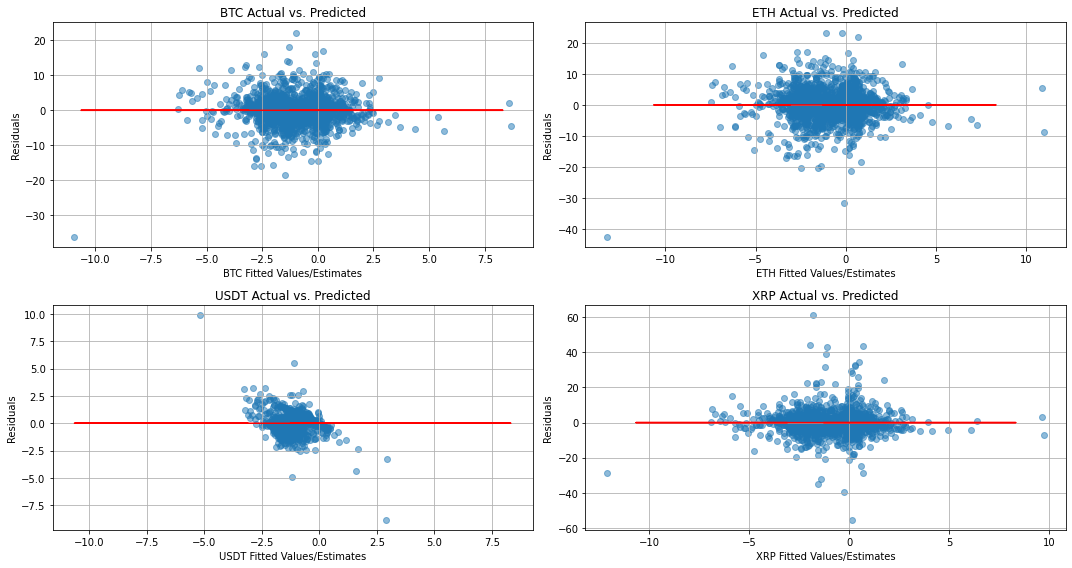

In [55]:
fig, ax = plt.subplots(figsize = (15, 8))
for i, crypto in enumerate(residuals_r):
    plt.subplot(2, 2, i+1)
    # Plotting residuals
    plt.scatter(fitted_r[crypto], residuals_r[crypto], alpha = 0.5)
    #sns.jointplot(x = fitted[crypto], y = residuals[crypto], kind='hex', height = 8)
    plt.title(f"{crypto} Actual vs. Predicted")
    plt.xlabel(f"{crypto} Fitted Values/Estimates")
    plt.ylabel("Residuals")
    # Line of best fit
    coeff, ssr, _, _, _ = np.polyfit(fitted_r[crypto], residuals_r[crypto], 1, full = True)
    plt.plot(capm_data['SP500'], coeff[0] * capm_data['SP500'] + coeff[1], "-", color = 'r')
    plt.grid()
    plt.tight_layout()

In [56]:
gq_test = pd.DataFrame(gq_test_r)
white_test_r = pd.DataFrame(white_test_r)
bp_test = pd.DataFrame(bp_test_r)

In [82]:
dw_r

{'BTC': 2.042588449198919,
 'ETH': 2.079726352708713,
 'USDT': 1.7546692903704275,
 'XRP': 1.9830791581713179}

In [57]:
round(white_test_r, 3).T

,White Lagrange Multiplier Statistic,White p-value,White f-statistic,White f p-value
BTC,215.456,0.00,122.585,0.000
ETH,194.895,0.00,109.426,0.000
USDT,784.484,0.00,707.760,0.000
XRP,1.783,0.41,0.891,0.411


In [58]:
round(white_test, 3).T

,White Lagrange Multiplier Statistic,White p-value,White f-statistic,White f p-value
BTC,215.456,0.00,122.585,0.000
ETH,194.895,0.00,109.426,0.000
USDT,784.484,0.00,707.760,0.000
XRP,1.783,0.41,0.891,0.411


## E. 95% confidence interval for Beta (Assumed normally distributed)

In [59]:
beta_r

{'BTC': 1.0344471474042773,
 'ETH': 1.2750325203845005,
 'USDT': 0.4295362891665916,
 'XRP': 1.1497556201369248}

In [60]:
# Making empty dict for values 
d_t_test = {}

# Defining Hypothesis of T-Test
hypothesis = 'SP500 = 1'

# Looping through all crypto and recording values
for crypto in beta:
    t_test = results_r[crypto].t_test(hypothesis)
    coef = t_test.effect
    se_t = t_test.sd
    t_v = t_test.tvalue
    ttest = t_test.pvalue
    upper = (coef+(1.96*se_t))
    lower = (coef-(1.96*se_t))
    
    d_t_test[crypto] = {"coef": float(coef), 
                        "std_err": float(se_t), 
                        "t-value": float(t_v), 
                        "p-value": float(ttest), 
                        "[0.025": float(lower),
                        "0.975]": float(upper)}

In [61]:
round(pd.DataFrame(d_t_test),3).T

,coef,std_err,t-value,p-value,[0.025,0.975]
BTC,1.034,0.111,0.310,0.757,0.817,1.252
ETH,1.275,0.147,1.866,0.062,0.986,1.564
USDT,0.430,0.083,-6.912,0.000,0.268,0.591
XRP,1.150,0.120,1.247,0.212,0.914,1.385


## F. Split Sample in 200 x 2 

In [84]:
s1 = {}
s2 = {}
residuals = {}
results = {}
fitted = {}
se = {}
beta = {}
gq_test = {}
white_test = {}
bp_test = {}
bg_test = {}
dw = {}
jb = {}
alpha = {}

for i in log_crypto:
    s1[i] = main(i, split = True, rs = 94238)
    s2[i] = main(i, split = True)

In [63]:
for i in s2:
    print(f"====================================={i}======================================\n{s1[i].summary()}\n")

=====================================BTC======================================
                            OLS Regression Results                            
Dep. Variable:                    BTC   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     70.76
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           7.94e-15
Time:                        21:55:04   Log-Likelihood:                -567.91
No. Observations:                 200   AIC:                             1140.
Df Residuals:                     198   BIC:                             1146.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

c:\users\csome\python\pythonproject\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\csome\python\pythonproject\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\csome\python\pythonproject\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

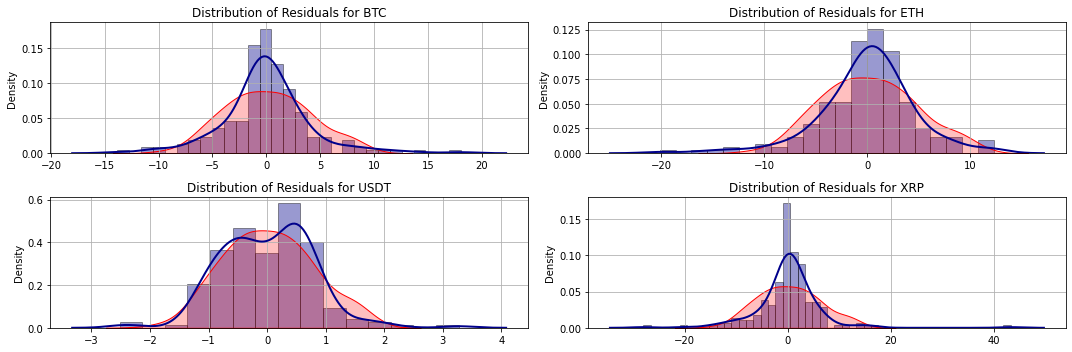

In [64]:
plt.figure(figsize = (15,5))
for i, crypto in enumerate(residuals):
    plt.subplot(2, 2, i+1)
    plt.title(f"Distribution of Residuals for {crypto}")
    sns.distplot(residuals[crypto], hist=True, kde=True, color='darkblue',hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2})
    np.random.seed(0)
    # Random variable with normal distribution
    normal_sample = np.random.normal(np.mean(residuals[crypto]),np.std(residuals[crypto]), 249)
    # Applying the Gaussian kernel density estimate to get the density curve
    sns.kdeplot(normal_sample, color = 'red', shade=True) 
    
    plt.grid()
    plt.tight_layout()

In [65]:
jb_test_df = round(pd.DataFrame(jb),3)
jb_test_df

,BTC,ETH,USDT,XRP
Jarque-Bera,102.542,77.118,14.551,1551.169
Chi^2 two-tail prob.,0.000,0.000,0.001,0.000
Skewness,0.489,-0.711,0.241,0.995
Kurtosis,6.369,5.689,4.230,16.497


In [66]:
# Split 1 
headers = ["BTC", "ETH", "USDT", "XRP"]
    
results_list = [main("BTC", split = True, rs = 94238),
                main("ETH", split = True, rs = 94238),
                main("USDT", split = True, rs = 94238),
                main("XRP", split = True, rs = 94238)]

result_table_1 = summary_col(results_list,
                           float_format = "%0.3f",
                           stars = True, 
                           model_names = headers)
result_table_1

,BTC,ETH,USDT,XRP
const,0.546,0.486,-0.744***,-0.132
,(0.354),(0.471),(0.084),(0.724)
SP500,1.533***,1.775***,0.278***,1.198***
,(0.182),(0.242),(0.043),(0.373)
R-squared,0.263,0.213,0.174,0.050
R-squared Adj.,0.260,0.209,0.170,0.045


In [67]:
results_list

In [68]:
# split 2
headers = ["BTC", "ETH", "USDT", "XRP"]
    
results_list = [main("BTC", split = True),
                main("ETH", split = True),
                main("USDT", split = True),
                main("XRP", split = True)]

result_table_2 = summary_col(results_list,
                           float_format = "%0.3f",
                           stars = True, 
                           model_names = headers)
result_table_2

,BTC,ETH,USDT,XRP
const,0.153,0.123,-0.585***,-0.540
,(0.358),(0.412),(0.069),(0.551)
SP500,1.040***,1.171***,0.452***,0.896***
,(0.210),(0.242),(0.041),(0.324)
R-squared,0.110,0.106,0.384,0.037
R-squared Adj.,0.105,0.101,0.381,0.032


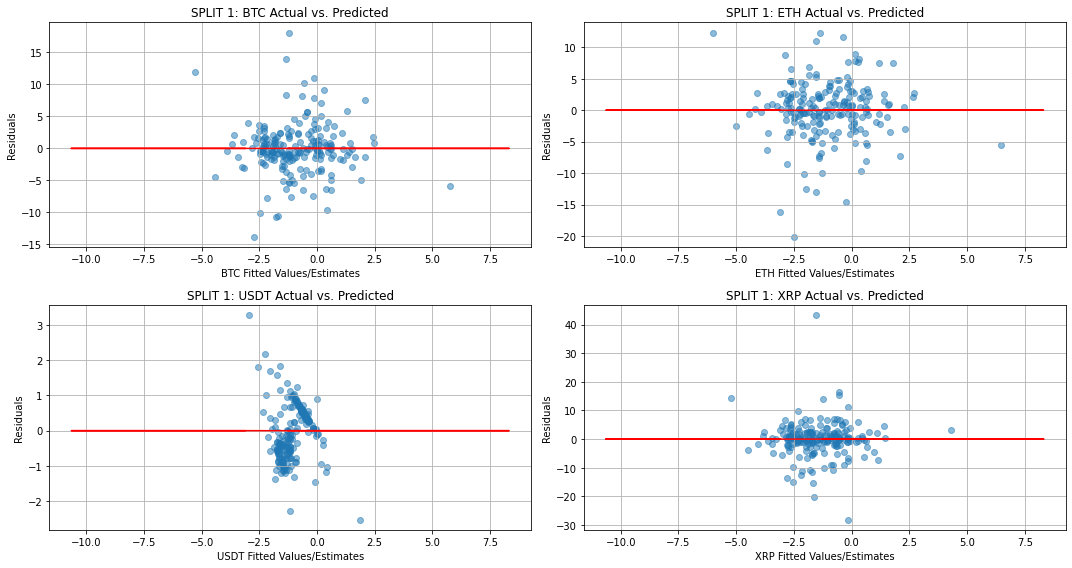

In [69]:
fig, ax = plt.subplots(figsize = (15, 8))
for i, crypto in enumerate(residuals):
    plt.subplot(2, 2, i+1)
    # Plotting residuals
    plt.scatter(fitted[crypto], residuals[crypto], alpha = 0.5)
    #sns.jointplot(x = fitted[crypto], y = residuals[crypto], kind='hex', height = 8)
    plt.title(f"SPLIT 1: {crypto} Actual vs. Predicted")
    plt.xlabel(f"{crypto} Fitted Values/Estimates")
    plt.ylabel("Residuals")
    # Line of best fit
    coeff, ssr, _, _, _ = np.polyfit(fitted[crypto], residuals[crypto], 1, full = True)
    plt.plot(capm_data['SP500'], coeff[0] * capm_data['SP500'] + coeff[1], "-", color = 'r')
    plt.grid()
    plt.tight_layout()

In [70]:
round(pd.DataFrame(bp_test), 3).T

,Breush-Pagan Lagrange Multiplier Statistic,BP p-value,BP f-value,BP f p-value
BTC,0.359,0.549,0.356,0.552
ETH,1.309,0.253,1.304,0.255
USDT,6.773,0.009,6.940,0.009
XRP,0.015,0.904,0.014,0.904


In [85]:
dw

{'BTC': 1.6803639029725987,
 'ETH': 1.7956364304491235,
 'USDT': 1.7855300283112663,
 'XRP': 1.8855972159575283}

## No Intercept

In [71]:
residuals = {}
results = {}
fitted = {}
se = {}
beta = {}
gq_test = {}
white_test = {}
bp_test = {}
bg_test = {}
dw = {}
alpha = {}
jb = {}
no_con = {}

for i in log_crypto: 
    no_con[i] = main(i, const = False)

In [72]:
for model in no_con:
    print(f"====================================={model}======================================\n{no_con[model].summary()}\n")

=====================================BTC======================================
                                 OLS Regression Results                                
Dep. Variable:                    BTC   R-squared (uncentered):                   0.164
Model:                            OLS   Adj. R-squared (uncentered):              0.164
Method:                 Least Squares   F-statistic:                              344.3
Date:                Sun, 23 Oct 2022   Prob (F-statistic):                    2.53e-70
Time:                        21:55:07   Log-Likelihood:                         -4912.8
No. Observations:                1756   AIC:                                      9828.
Df Residuals:                    1755   BIC:                                      9833.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err         

In [73]:
# Split 1 
headers = ["BTC", "ETH", "USDT", "XRP"]
    
results_list = [main("BTC", const = False),
                main("ETH", const = False),
                main("USDT", const = False),
                main("XRP", const = False)]

result_table_1 = summary_col(results_list,
                           float_format = "%0.3f",
                           stars = True, 
                           model_names = headers)
result_table_1

,BTC,ETH,USDT,XRP
SP500,1.010***,1.152***,0.647***,1.095***
,(0.054),(0.069),(0.014),(0.087)
R-squared,0.164,0.137,0.566,0.083
R-squared Adj.,0.164,0.137,0.565,0.082


In [74]:
round(pd.DataFrame(gq_test),2)

,BTC,ETH,USDT,XRP
GQ F-statistic,0.63,0.8,0.2,0.98
GQ p-value,1.00,1.0,1.0,0.62


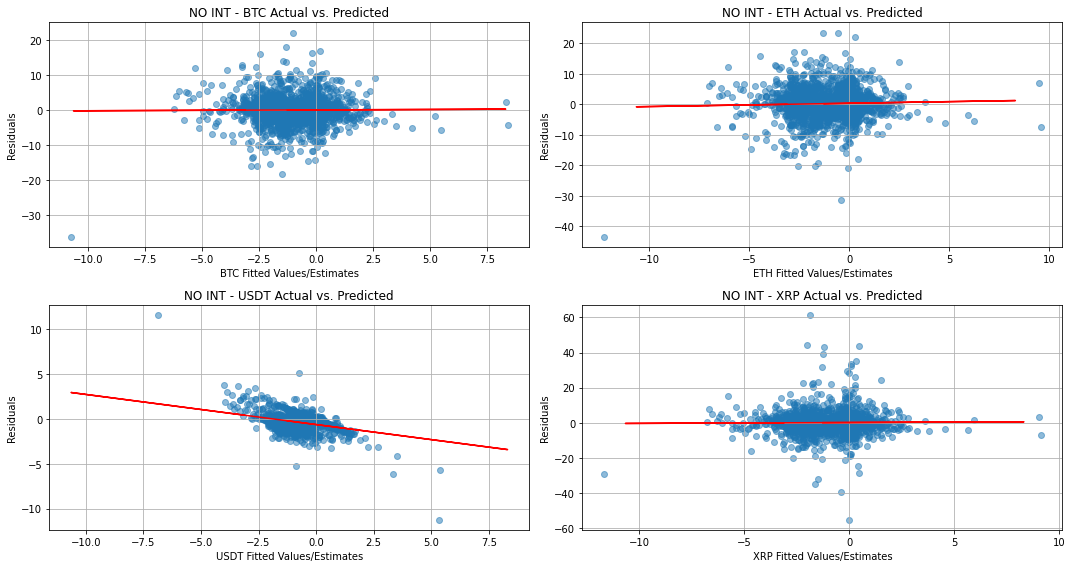

In [75]:
fig, ax = plt.subplots(figsize = (15, 8))
for i, crypto in enumerate(residuals):
    plt.subplot(2, 2, i+1)
    # Plotting residuals
    plt.scatter(fitted[crypto], residuals[crypto], alpha = 0.5)
    #sns.jointplot(x = fitted[crypto], y = residuals[crypto], kind='hex', height = 8)
    plt.title(f"NO INT - {crypto} Actual vs. Predicted")
    plt.xlabel(f"{crypto} Fitted Values/Estimates")
    plt.ylabel("Residuals")
    # Line of best fit
    coeff, ssr, _, _, _ = np.polyfit(fitted[crypto], residuals[crypto], 1, full = True)
    plt.plot(capm_data['SP500'], coeff[0] * capm_data['SP500'] + coeff[1], "-", color = 'r')
    plt.grid()
    plt.tight_layout()

## Comparing All models

#### BTC

=====================================BTC======================================
                            OLS Regression Results                            
Dep. Variable:                    BTC   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     229.0
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           1.03e-48
Time:                        21:57:56   Log-Likelihood:                -4912.6
No. Observations:                1756   AIC:                             9829.
Df Residuals:                    1754   BIC:                             9840.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

,non_robust_OLS,robust_OLS,sample_1,rob_sample_1,sample_2,rob_sample_2,no_constant,rob_no_con
R-squared,0.115,0.115,0.231,0.231,0.110,0.110,0.164,0.164
R-squared Adj.,0.115,0.115,0.227,0.227,0.105,0.105,0.164,0.164
SP500,1.034***,1.034***,1.807***,1.807***,1.040***,1.040***,1.010***,1.010***
,(0.068),(0.111),(0.234),(0.691),(0.210),(0.219),(0.054),(0.085)
const,0.071,0.071,0.796*,0.796,0.153,0.153,,
,(0.119),(0.133),(0.448),(0.794),(0.358),(0.317),,


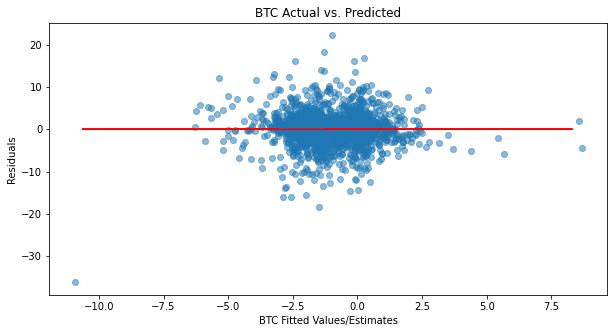

In [78]:
results["BTC"] = main("BTC")
s1 = main("BTC", split = True, rs = 555)
s1_r = main("BTC", "r", split = True, rs = 555)
s2 = main("BTC", split = True)
s2_r = main("BTC", "r", split = True)
no_con = main("BTC", const = False) 
no_con_r = main("BTC", "r", const = False)

tabulate(results["BTC"], results_r["BTC"], 7, s1, s1_r, s2, s2_r, no_con, no_con_r)

#### ETH

=====================================ETH======================================
                            OLS Regression Results                            
Dep. Variable:                    ETH   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     217.8
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           1.49e-46
Time:                        21:59:36   Log-Likelihood:                -5323.8
No. Observations:                1756   AIC:                         1.065e+04
Df Residuals:                    1754   BIC:                         1.066e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

,non_robust_OLS,robust_OLS,sample_1,rob_sample_1,sample_2,rob_sample_2,no_constant,rob_no_con
R-squared,0.110,0.110,0.218,0.218,0.106,0.106,0.137,0.137
R-squared Adj.,0.110,0.110,0.214,0.214,0.101,0.101,0.137,0.137
SP500,1.275***,1.275***,2.125***,2.125***,1.171***,1.171***,1.152***,1.152***
,(0.086),(0.147),(0.286),(0.768),(0.242),(0.264),(0.069),(0.117)
const,0.355**,0.355**,0.936*,0.936,0.123,0.123,,
,(0.150),(0.165),(0.548),(0.818),(0.412),(0.416),,


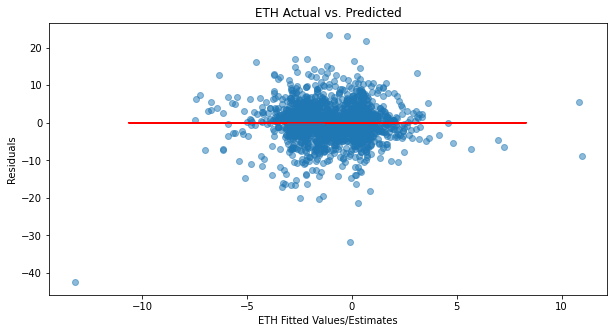

In [79]:
results["ETH"] = main("ETH")
s1 = main("ETH", split = True, rs = 555)
s1_r = main("ETH", "r", split = True, rs = 555)
s2 = main("ETH", split = True)
s2_r = main("ETH", "r", split = True)
no_con = main("ETH", const = False)
no_con_r = main("ETH", "r", const = False)

tabulate(results["ETH"], results_r["ETH"], 7, s1, s1_r, s2, s2_r, no_con, no_con_r)

#### USDT

=====================================USDT======================================
                            OLS Regression Results                            
Dep. Variable:                   USDT   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     856.8
Date:                Sun, 23 Oct 2022   Prob (F-statistic):          1.04e-153
Time:                        21:59:44   Log-Likelihood:                -2210.7
No. Observations:                1756   AIC:                             4425.
Df Residuals:                    1754   BIC:                             4436.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

,non_robust_OLS,robust_OLS,sample_1,rob_sample_1,sample_2,rob_sample_2,no_constant,rob_no_con
R-squared,0.328,0.328,0.121,0.121,0.384,0.384,0.566,0.566
R-squared Adj.,0.328,0.328,0.117,0.117,0.381,0.381,0.565,0.565
SP500,0.430***,0.430***,0.252***,0.252,0.452***,0.452***,0.647***,0.647***
,(0.015),(0.083),(0.048),(0.171),(0.041),(0.066),(0.014),(0.073)
const,-0.626***,-0.626***,-0.730***,-0.730***,-0.585***,-0.585***,,
,(0.026),(0.090),(0.092),(0.183),(0.069),(0.084),,


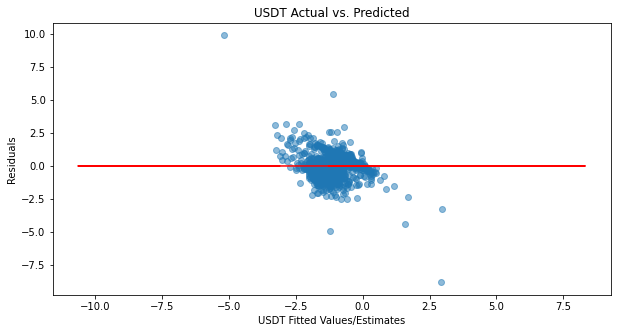

In [80]:
results["USDT"] = main("USDT")
s1 = main("USDT", split = True, rs = 555)
s1_r = main("USDT", "r", split = True, rs = 555)
s2 = main("USDT", split = True)
s2_r = main("USDT", "r", split = True)
no_con = main("USDT", const = False)
no_con_r = main("USDT", "r", const = False)

tabulate(results["USDT"], results_r["USDT"], 7, s1, s1_r, s2, s2_r, no_con, no_con_r)

#### XRP

=====================================XRP======================================
                            OLS Regression Results                            
Dep. Variable:                    XRP   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     110.6
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           4.01e-25
Time:                        21:59:46   Log-Likelihood:                -5737.3
No. Observations:                1756   AIC:                         1.148e+04
Df Residuals:                    1754   BIC:                         1.149e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

,non_robust_OLS,robust_OLS,sample_1,rob_sample_1,sample_2,rob_sample_2,no_constant,rob_no_con
R-squared,0.059,0.059,0.050,0.050,0.037,0.037,0.083,0.083
R-squared Adj.,0.059,0.059,0.045,0.045,0.032,0.032,0.082,0.082
SP500,1.150***,1.150***,1.198***,1.198**,0.896***,0.896***,1.095***,1.095***
,(0.109),(0.120),(0.373),(0.513),(0.324),(0.242),(0.087),(0.096)
const,0.157,0.157,-0.132,-0.132,-0.540,-0.540,,
,(0.190),(0.212),(0.724),(0.581),(0.551),(0.617),,


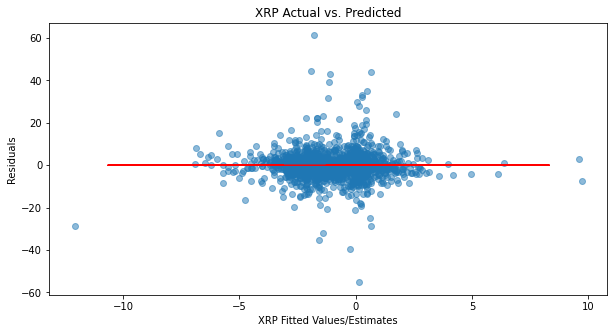

In [81]:
results["XRP"] = main("XRP")
s1 = main("XRP", split = True, rs = 94238)
s1_r = main("XRP", "r", split = True, rs = 94238)
s2 = main("XRP", split = True)
s2_r = main("XRP", "r", split = True)
no_con = main("XRP", const = False)
no_con_r = main("XRP", "r", const = False)

tabulate(results["XRP"], results_r["XRP"], 7, s1, s1_r, s2, s2_r, no_con, no_con_r)